In [9]:
import os
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.feature import hog, graycomatrix, graycoprops
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

In [ ]:
IMG_DIR = "./package/Images"
GT_DIR = "./package/GroundTruths"
FOA_TRN_DIR = "./package/FOA/exp_C/exp_C1/trn" # img1 to img42
FOA_TST_DIR = "./package/FOA/exp_C/exp_C1/tst" # img79 to img134

CHIP_SIZE = 32
PROB_THRESHOLD = 0.5
IOU_THRESHOLD = 0.3

In [10]:
def vread(basepath):
    with open(basepath + ".spr", "r") as f:
        ndim = int(f.readline())
        if ndim != 2:
            raise ValueError("Only 2D images supported")

        nc = int(f.readline())
        f.readline(); f.readline()
        nr = int(f.readline())
        f.readline(); f.readline()
        dtype_code = int(f.readline())

    dtype_map = {0: np.uint8, 2: np.int32, 3: np.float32, 5: np.float64}
    dtype = dtype_map[dtype_code]

    with open(basepath + ".sdt", "rb") as f:
        data = np.frombuffer(f.read(), dtype=dtype)

    data = data[:nr * nc]
    return data.reshape(nr, nc)

def load_lxyr(path):
    gts = []
    with open(path, "r") as f:
        for line in f:
            label, x, y, r = line.strip().split()
            if int(label) > 0:
                gts.append((int(float(x)), int(float(y)), int(float(r))))
    return gts

def load_lxyv(path):
    points = []
    with open(path, "r") as f:
        for line in f:
            label, x, y, _ = line.strip().split()
            points.append((1 if int(label) > 0 else 0, int(float(x)), int(float(y))))
    return points

In [4]:
def preprocess(img):
    img = cv2.medianBlur(img, 3)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(32, 32))
    return clahe.apply(img.astype(np.uint8))

def extract_chip(img, cx, cy, size=32):
    h, w = img.shape
    half = size // 2

    x1 = max(0, cx - half)
    y1 = max(0, cy - half)
    x2 = min(w, cx + half)
    y2 = min(h, cy + half)

    chip = img[y1:y2, x1:x2]

    return cv2.copyMakeBorder(
        chip,
        top=max(0, size - chip.shape[0]),
        bottom=0,
        left=max(0, size - chip.shape[1]),
        right=0,
        borderType=cv2.BORDER_REFLECT
    )

def extract_features(chip):
    chip = cv2.resize(chip, (32, 32))

    hog_feat = hog(
        chip,
        orientations=6,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2",
        visualize=False
    )

    glcm = graycomatrix(
        chip,
        distances=[1, 2],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=256,
        symmetric=True,
        normed=True
    )

    glcm_feats = []
    for prop in ("contrast", "homogeneity", "energy", "correlation"):
        glcm_feats.extend(graycoprops(glcm, prop).flatten())

    return np.hstack([hog_feat, glcm_feats])

In [5]:
def build_dataset(foa_dir):
    X, y = [], []

    for fname in tqdm(os.listdir(foa_dir)):
        if not fname.endswith(".lxyv"):
            continue

        img_id = fname.replace(".lxyv", "")
        img = vread(os.path.join(IMG_DIR, img_id))
        img = preprocess(img)

        points = load_lxyv(os.path.join(foa_dir, fname))

        for label, x, y_coord in points:
            chip = extract_chip(img, x, y_coord, CHIP_SIZE)
            feat = extract_features(chip)

            X.append(feat)
            y.append(label)

    return np.array(X), np.array(y)

print("Building training set from FOA (trn)...")
X_train, y_train = build_dataset(FOA_TRN_DIR)

Building training set from FOA (trn)...


100%|██████████| 131/131 [16:03<00:00,  7.35s/it]


In [11]:
def box_from_center(cx, cy, size):
    half = size // 2
    return (
        cx - half, cy - half,
        cx + half, cy + half
    )

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_w = max(0, xB - xA)
    inter_h = max(0, yB - yA)
    inter_area = inter_w * inter_h

    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    union = areaA + areaB - inter_area
    if union == 0:
        return 0.0

    return inter_area / union

def evaluate_iou(detections, gt_volcanoes, chip_size, iou_thresh=0.3):
    gt_used = [False] * len(gt_volcanoes)
    ious = []

    TP = FP = 0

    for px, py, _ in detections:
        pred_box = box_from_center(px, py, chip_size)

        best_iou = 0
        best_idx = -1

        for i, (gx, gy, _) in enumerate(gt_volcanoes):
            if gt_used[i]:
                continue

            gt_box = box_from_center(gx, gy, chip_size)
            iou = compute_iou(pred_box, gt_box)

            if iou > best_iou:
                best_iou = iou
                best_idx = i

        if best_iou >= iou_thresh:
            TP += 1
            gt_used[best_idx] = True
            ious.append(best_iou)
        else:
            FP += 1

    FN = gt_used.count(False)
    mean_iou = np.mean(ious) if ious else 0.0

    return TP, FP, FN, mean_iou

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

svm = SVC(
    kernel="rbf",
    probability=True,
    class_weight="balanced"
)
svm.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True)

In [ ]:
X_test, y_test = build_dataset(FOA_TST_DIR)
X_test = scaler.transform(X_test)

probs = svm.predict_proba(X_test)[:, 1]
preds = (probs >= PROB_THRESHOLD).astype(int)

roc = roc_auc_score(y_test, probs)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, preds, average="binary"
)

cm = confusion_matrix(y_test, preds)

# print("\n===== EVALUATION RESULTS =====")
# print(f"ROC AUC           : {roc:.4f}")
# print(f"Precision         : {precision:.4f}")
# print(f"Recall (PD)       : {recall:.4f}")
# print(f"F1-score          : {f1:.4f}")
# print("\nConfusion Matrix:")
# print(cm)

joblib.dump(
    {
        "model": svm,
        "scaler": scaler,
        "chip_size": CHIP_SIZE,
        "hog": {
            "orientations": 6,
            "pixels_per_cell": (8, 8),
            "cells_per_block": (2, 2)
        },
        "glcm": {
            "distances": [1, 2],
            "angles": [0, 45, 90, 135]
        }
    },
    "volcano_detector.pkl" # name
)
print("\nModel saved: volcano_detector.pkl")

100%|██████████| 170/170 [13:55<00:00,  4.91s/it]



===== EVALUATION RESULTS =====
ROC AUC           : 0.9270
Precision         : 0.2436
Recall (PD)       : 0.5729
F1-score          : 0.3418

Confusion Matrix:
[[16055   354]
 [   85   114]]

Model saved as volcano_detector.pkl


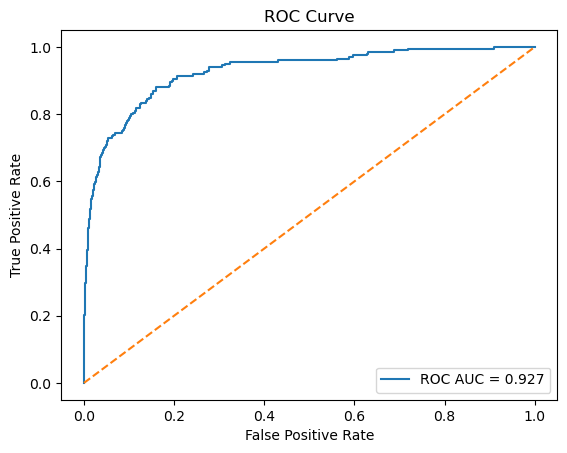

In [12]:
fpr, tpr, _ = roc_curve(y_test, probs)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

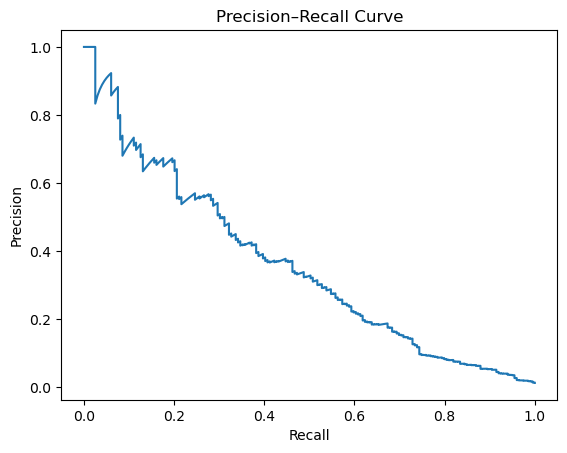

In [13]:
prec, rec, _ = precision_recall_curve(y_test, probs)

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

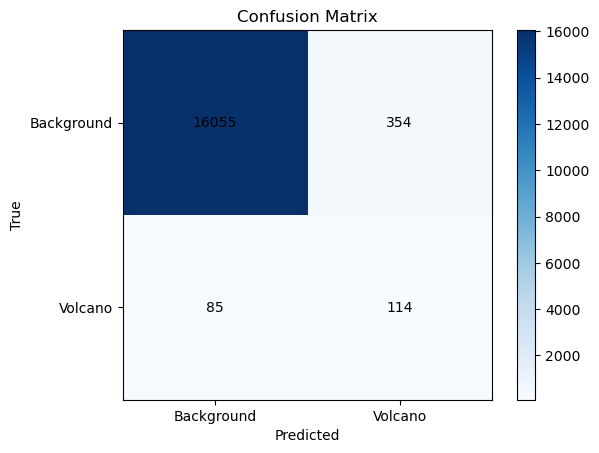

In [14]:
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.colorbar()

plt.xticks([0, 1], ["Background", "Volcano"])
plt.yticks([0, 1], ["Background", "Volcano"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [15]:
print("\nEvaluating detection IoU on test images...")

iou_scores = []
TP_total = FP_total = FN_total = 0

for fname in os.listdir(FOA_TST_DIR):
    if not fname.endswith(".lxyv"):
        continue

    img_id = fname.replace(".lxyv", "")

    img = vread(os.path.join(IMG_DIR, img_id))
    img = preprocess(img)

    foa_points = load_lxyv(os.path.join(FOA_TST_DIR, fname))
    gt_path = os.path.join("./GroundTruths", img_id + ".lxyr")

    if not os.path.exists(gt_path):
        continue

    gt_volcanoes = load_lxyr(gt_path)

    detections = []
    for label, x, y in foa_points:
        chip = extract_chip(img, x, y, CHIP_SIZE)
        feat = extract_features(chip)
        feat = scaler.transform([feat])
        prob = svm.predict_proba(feat)[0, 1]

        if prob >= PROB_THRESHOLD:
            detections.append((x, y, prob))

    TP, FP, FN, mean_iou = evaluate_iou(
        detections, gt_volcanoes, CHIP_SIZE
    )

    TP_total += TP
    FP_total += FP
    FN_total += FN
    iou_scores.append(mean_iou)

print("\n===== IoU DETECTION METRICS =====")
print(f"Precision : {TP_total / (TP_total + FP_total + 1e-6):.4f}")
print(f"Recall    : {TP_total / (TP_total + FN_total + 1e-6):.4f}")
print(f"Mean IoU  : {np.mean(iou_scores):.4f}")


Evaluating detection IoU on test images...

===== IoU DETECTION METRICS =====
Precision : 0.0000
Recall    : 0.0000
Mean IoU  : nan


c:\Users\u\anaconda3\envs\compvis\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\u\anaconda3\envs\compvis\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
